In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 9.1 군집

비슷한 샘플을 구별해 하나의 클러스터 또는 비슷한 샘플의 그룹으로 할당하는 작업

고객 분류(추천 시스템), 데이터 분석, 차원 축소 기법, 이상치 탐지(부정 거래 감지), 준지도 학습, 검색 엔진, 이미지 분할 등에 활용

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

그림 저장: classification_vs_clustering_plot


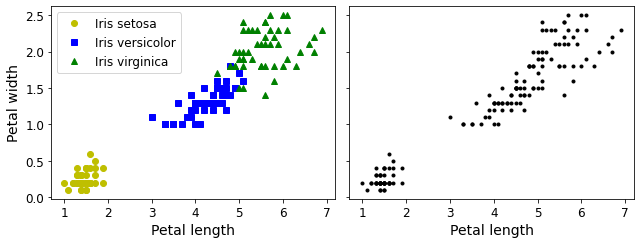

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

In [5]:
# 가우시안 혼합 모델은 3개의 클러스터를 잘 설명
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

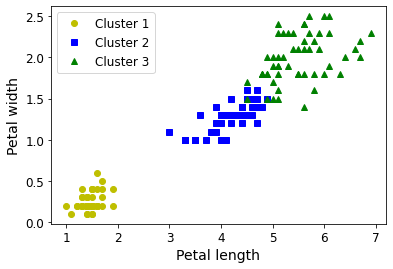

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
np.sum(y_pred==y)

145

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

### 9-1 k-평균

In [12]:
from sklearn.datasets import make_blobs

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [14]:
# blob_center 좌표를 기준으로 무작위 샘플 뿌리기

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [15]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

그림 저장: blobs_plot


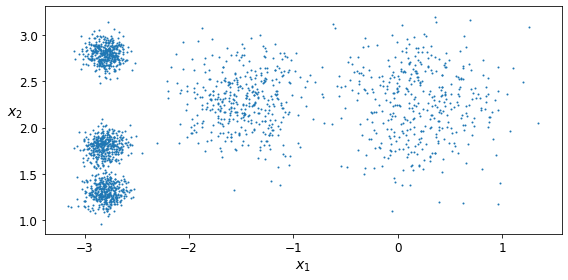

In [16]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

In [17]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [18]:
print(y_pred)
print(y_pred is kmeans.labels_)

[4 0 1 ... 2 1 0]
True


In [19]:
# 센트로이드의 좌표
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [20]:
# 새로운 샘플에 가장 가까운 센트로이드의 클러스터를 할당
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

In [21]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: voronoi_plot


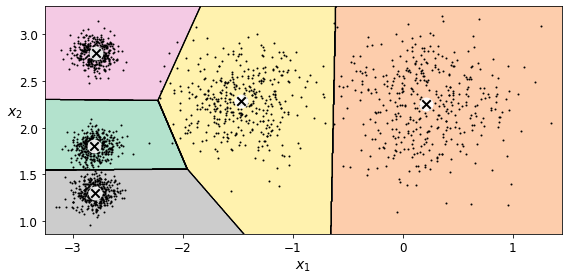

In [22]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

In [23]:
# 각 샘플과 클러스터 사이의 거리 반환
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [24]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### K-평균 알고리즘

1. 처음에는 데이터에서 k개의 랜덤 샘플을 선정하고 그 위치를 센트로이드로 정함

2. 수렴할 때까지 각 샘플을 가장 가까운 센트로이드에 할당한 후 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트

In [26]:
# K-평균 알고리즘의 반복 횟수(1, 2, 3)회 별 차이
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

그림 저장: kmeans_algorithm_plot


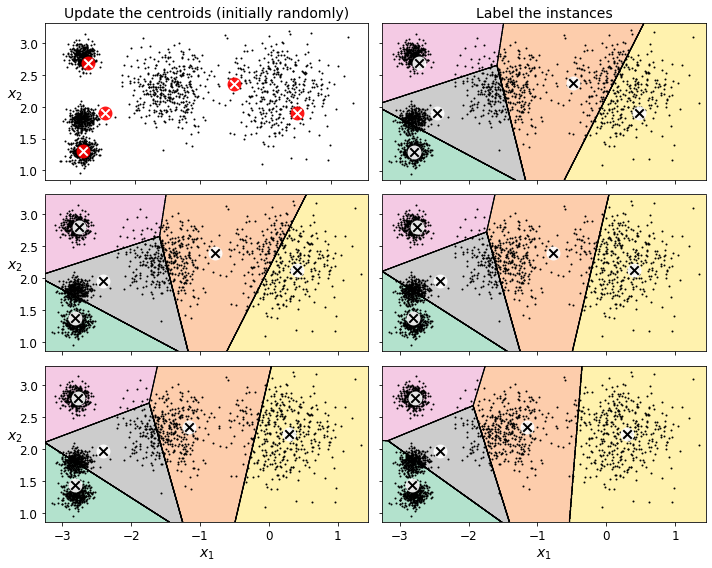

In [27]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

In [25]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

그림 저장: kmeans_variability_plot


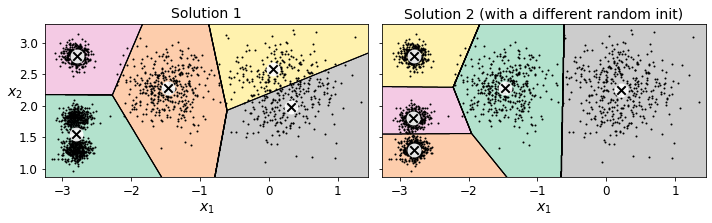

In [29]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

# K-평균 알고리즘은 초기화가 어떻게 되느냐에 따라 같은 반복횟수일 때 결과가 다를 수 있음

### 이너셔

각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합

In [30]:
kmeans.inertia_

211.5985372581684

In [31]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581688

In [32]:
# 사이킷런의 score는 항상 큰 값이 좋은 것이기 때문에 음수로 결과 나옴
kmeans.score(X)

-211.5985372581684

### 다중 초기화

In [33]:
kmeans_rnd_init1.inertia_

219.435394427714

In [34]:
kmeans_rnd_init2.inertia_

211.5985372581684

In [35]:
# n_init 옵션을 통해 알고리즘을 n_init 번 실행하고 가냥 이너셔가 작은 솔루션을 선택

kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

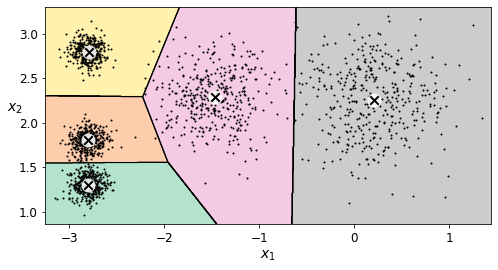

In [36]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### 센트로이드 초기화 방법

센트로이드를 완전히 랜덤하게 초기화하는 대신 David Arthur와 Sergei Vassilvitskii가 [2006년 논문](https://goo.gl/eNUPw6)에서 제안한 다음 알고리즘을 사용해 초기화하는 것이 더 좋습니다:
* 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택합니다.
* $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택합니다. 여기에서 $D(\mathbf{x}_i)$는 샘플 $\mathbf{x}_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리입니다. 이 확률 분포는 이미 선택한 센트로이드에서 멀리 떨어진 샘플을 센트로이드로 선택할 가능성을 높입니다.
* $k$ 개의 센트로이드를 선택할 때까지 이전 단계를 반복합니다.

In [37]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### k-평균 속도 개선

k-평균 알고리즘은 불필요한 거리 계산을 많이 피함으로써 속도를 노일 수 있음

In [38]:
# algorithm='elkan'이 그 불필요한 거리 계산을 피하는 알고리즘
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

113 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [39]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

730 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### 미니배치 k-평균

In [26]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [41]:
minibatch_kmeans.inertia_

211.65239850433204

In [27]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

데이터가 메모리에 들어가지 않을 경우 가장 간단한 해법은 memmap을 이용

In [44]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [45]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

데이터가 너무 커서 memmap도 사용할 수 없다면 문제는 복잡

In [29]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [30]:
np.random.seed(42)

In [31]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

In [49]:
best_kmeans.score(X)

-211.62571878891143

In [50]:
# 미니배치 k-평균이 일반 k-평균보다 빠르지만, 이너셔는 약간 높음
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

70.9 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

535 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
from timeit import timeit

In [53]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

1/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

2/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

3/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

4/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

5/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

6/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

7/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

8/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

9/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

10/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

11/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

12/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

13/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

14/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

15/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

16/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

17/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

18/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

19/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

20/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

21/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

22/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

23/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

24/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

25/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

26/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

27/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

28/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

29/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

30/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

31/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

32/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

33/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

34/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

35/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

36/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

37/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

38/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

39/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

40/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

41/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

42/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

43/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

44/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

45/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

46/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

47/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

48/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

49/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

50/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

51/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

52/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

53/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

54/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

55/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

56/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

57/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

58/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

59/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

60/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

61/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

62/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

63/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

64/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

65/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

66/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

67/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

68/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

69/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

70/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

71/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

72/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

73/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

74/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

75/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

76/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

77/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

78/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

79/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

80/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

81/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

82/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

83/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

84/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

85/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

86/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

87/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

88/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

89/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

90/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

91/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

92/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

93/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

94/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

95/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

96/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

97/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

98/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

99/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

100/100

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\clus

그림 저장: minibatch_kmeans_vs_kmeans


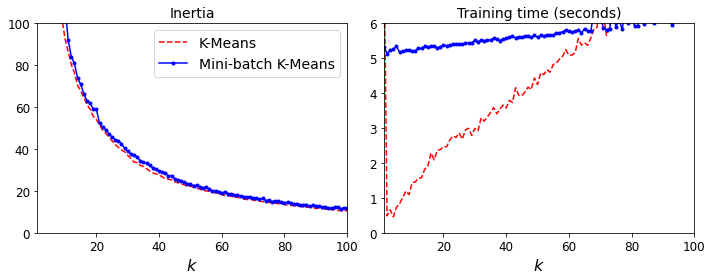

In [54]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### 최적의 클러스터 개수 찾기

그림 저장: bad_n_clusters_plot


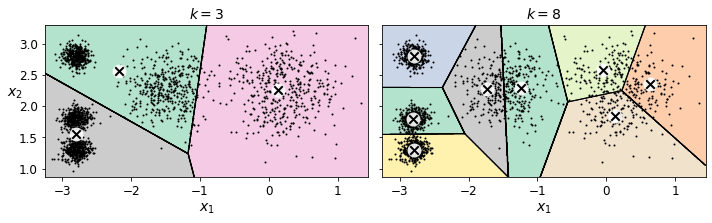

In [58]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

이너샤는 단순히 k의 개수가 커짐에 따라 작아지기 때문에, 이너샤를 기준으로 최적의 클러스터 개수를 정하는 것은 한계가 있음

In [56]:
kmeans_k3.inertia_

653.2167190021553

In [57]:
kmeans_k8.inertia_

119.1198341610288

In [59]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

그림 저장: inertia_vs_k_plot


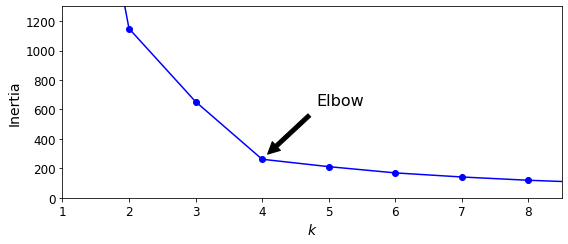

In [60]:
# k=4인 엘보지점이 최적점으로 보이지만, 확실한 것은 아님

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

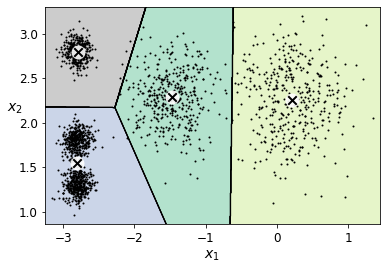

In [61]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

또 다른 방법은 모든 샘플에 대한 _실루엣 계수_ 의 평균인 _실루엣 점수_ 입니다. 한 샘플의 실루엣 계수는 $(b - a)/\max(a, b)$입니다. 여기에서 $a$는 같은 클러스터에 있는 다른 샘플까지의 평균 거리입니다(이를 _클러스터 내부 평균 거리_ 라고 합니다). $b$는 가장 가까운 클러스터까지 평균 거리입니다. 즉 가장 가까운 클러스터(샘플 자신의 클러스터를 제외하고 $b$를 최소화하는 클러스터)의 샘플까지 평균 거리입니다. 실루엣 계수는 -1에서 +1 사이 값을 가집니다. +1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터 안에 잘 있다는 것을 의미합니다.0에 가까우면 클러스터 경계에 가깝다는 의미입니다. -1에 가까우면 샘플이 잘못된 클러스터에 할당되었을지 모릅니다.

In [34]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [63]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

그림 저장: silhouette_score_vs_k_plot


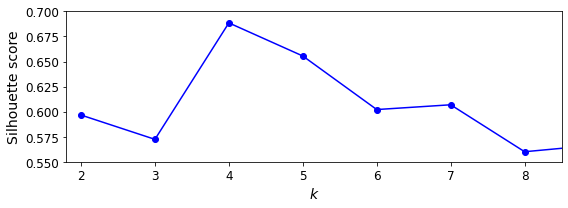

In [64]:
# 이 결과를 통해 k=4가 좋은 선택이지만 k=5도 꽤 좋다는 사실을 보여줌

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")

plt.show()

실루엣 다이어그램, 많은 샘플이 파선의 왼쪽에서 멈추면 클러스터의 샘플이 다른 클러스터랑 너무 가깝다는 의미. 나쁜 클러스터임

그림 저장: silhouette_analysis_plot


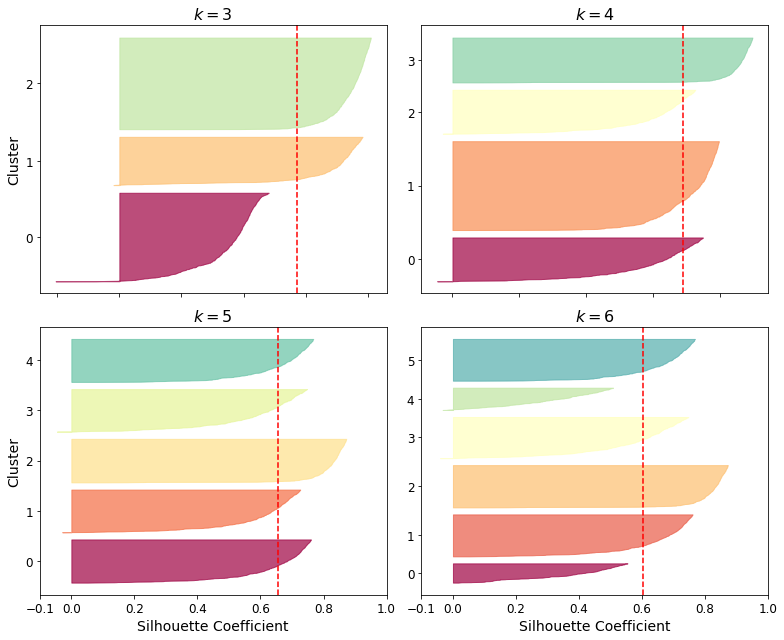

In [65]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

## 9.1.2 k-평균의 한계

최적이 아닌 솔루션을 피하려면 알고리즘은 여러번 실행해야하고, 클러스터의 개수를 지정해줘야함. 또한, 클러스터의 크기나 밀집도가 서로 다르거나 원형이 아닐 경우 잘 작동하지 않음

In [66]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

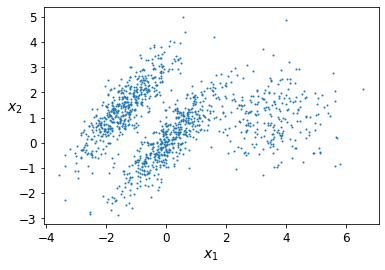

In [67]:
plot_clusters(X)

In [68]:
# init 옵션으로 최초 센트로이드 좌표 지정
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

그림 저장: bad_kmeans_plot


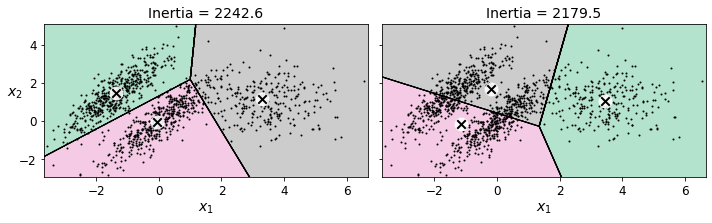

In [69]:
# k-평균 알고리즘으 세 개의 타원형 클러스터를 적절히 구분하지 못함
# 이런 타원형 클러스터에서는 가우시안 혼합 모델이 잘 작동
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

## 9.1.3 군집을 사용한 이미지 분할

이미지 분할 : 이미지를 세그먼트 여러 개로 분할하는 작업

시멘틱 분할 : 동일한 종류의 물체에 속한 모든 픽셀은 같은 세그먼트에 할당됨

색상 분할 : 동일한 색상을 가진 픽셀을 같은 세그먼트에 할당

In [35]:
# 무당벌레 이미지를 다운로드합니다
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x217f2a64040>)

In [36]:
from matplotlib.image import imread
image = imread(os.path.join('images', 'unsupervised_learning', 'ladybug.png'))
image.shape

(533, 800, 3)

In [37]:
X = image.reshape(-1, 3)       # -1은 열이 3개가 오도록 하고, 행의 수를 그에 맞춰 설정하기
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [38]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

그림 저장: image_segmentation_diagram


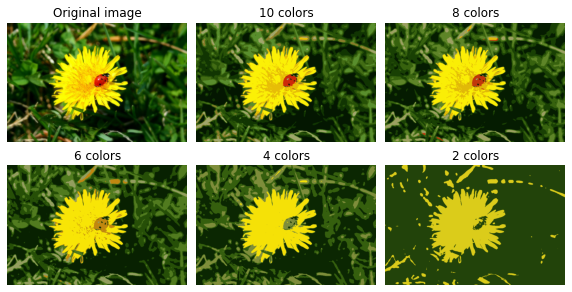

In [39]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

## 9.1.4 군집을 사용한 전처리

In [40]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y = True)

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [42]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [43]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

In [44]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)),
    ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)),
    ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [45]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

In [46]:
# 50개의 클러스터로 만든 뒤 로지스틱 회귀를 적용하니 약 30%까지 오차율을 줄일 수 있었음
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

In [48]:
# GridSearchCV를 이용한 최적의 클러스터 개수 찾기
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters = range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   5.0s
[CV] END ..............................kmeans__n_clusters=36; total time=   5.2s
[CV] END ..............................kmeans__n_clusters=36; total time=   5.2s
[CV] END ..............................kmeans__n_clusters=36; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=37; total time=   4.6s
[CV] END ..............................kmeans__n_clusters=37; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=37; total time=   5.3s
[CV] END ..............................kmeans__n_clusters=38; total time=   4.3s
[CV] END ..............................kmeans__n_clusters=38; total time=   5.4s
[CV] END ..............................kmeans__n_clusters=38; total time=   5.0s
[CV] END ..............................kmeans__n_clusters=39; total time=   5.2s
[CV] END ..............................kmeans__n_clusters=39; total time=   5.5s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   5.9s
[CV] END ..............................kmeans__n_clusters=70; total time=   5.7s
[CV] END ..............................kmeans__n_clusters=70; total time=   5.8s
[CV] END ..............................kmeans__n_clusters=70; total time=   5.3s
[CV] END ..............................kmeans__n_clusters=71; total time=   5.7s
[CV] END ..............................kmeans__n_clusters=71; total time=   5.6s
[CV] END ..............................kmeans__n_clusters=71; total time=   6.1s
[CV] END ..............................kmeans__n_clusters=72; total time=   6.3s
[CV] END ..............................kmeans__n_clusters=72; total time=   6.7s
[CV] END ..............................kmeans__n_clusters=72; total time=   6.2s
[CV] END ..............................kmeans__n_clusters=73; total time=   6.0s
[CV] END ..............................kmeans__n_clusters=73; total time=   5.9s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [92]:
grid_clf.best_params_

{'kmeans__n_clusters': 58}

In [93]:
grid_clf.score(X_test, y_test)

0.9777777777777777

## 9.1.5 군집을 이용한 준지도학습

In [49]:
n_labeled = 50
log_reg = LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
log_reg.score(X_test, y_test)

0.8266666666666667

In [51]:
# fit_transform을 이용해 각 센트로이드로부터의 거리를 반환받은 다음, 가장 큰 50개를 대표이미지로 선정
k=50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist=  kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

그림 저장: representative_images_diagram


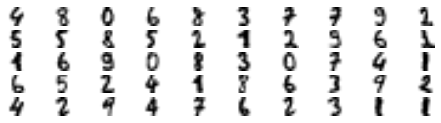

In [52]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [53]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [59]:
y_representative_digits = np.array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
                                   5, 5, 8, 5, 2, 1, 2, 5, 6, 1,
                                   1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
                                   6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
                                   4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

성능이 확 좋아짐, 레이블을 부여하는 건 비용이 많이 들기 때문에 무작위 샘플 대신 대표 샘플에 레이블을 할당하는 것이 좋은 방법

In [60]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9088888888888889

In [61]:
# 레이블 전파(동일한 클러스터에 있는 모든 샘플에 에리블을 전파)
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [62]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [63]:
log_reg.score(X_test, y_test)

0.9133333333333333

모든 샘플에 레이블은 전파했기 때문에 성능 증가폭이 크지 않음. 왜냐하면 클러스터에 경계에 위치해있지만 확실하게 정답이 아닌 샘플이 포함될 수 있기 때문 -> 센트로이드와 가까운 20%만 레이블 전파

In [64]:
percentile_closest=20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [65]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

In [67]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [68]:
log_reg.score(X_test, y_test)

0.9466666666666667

In [69]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

1.0

## 9.1.6 DBSCAN

- 알고리즘이 각 샘플에서 작은 거리인 $\epsilon$ 내에 샘플이 몇 개 놓여 있는지 세고, 이 지역을 샘플의 $\epsilon$-이웃이라고 부름
- $\epsilon$-이웃 내에 적어도 min_samples개 샘플이 있다면 이를 핵심 샘플로 간주
- 핵심 샘플의 이웃에 있는 모든 샘플은 동일한 클러스터에 포함
- 핵심 샘플이 아니고 이웃도 아닌 샘플은 이상치

In [71]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [72]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [74]:
dbscan.labels_[:10]        # -1로 기록된 라벨은 이상치로 탐지했다는 의미

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [76]:
print(len(dbscan.core_sample_indices_))         # core_sample_indices_는 핵심 샘플의 인덱스
print(dbscan.core_sample_indices_[:10])
dbscan.components_[:3]           # 핵심 샘플의 값

808
[ 0  4  5  6  7  8 10 11 12 13]


array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [77]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [78]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [79]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

그림 저장: dbscan_plot


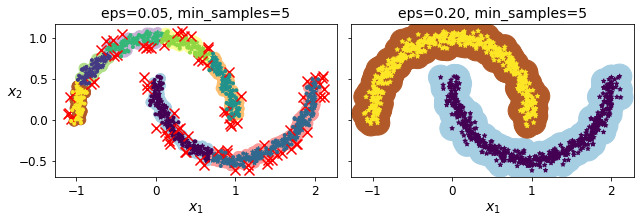

In [80]:
# eps값에 따른 이상치 판단 차이(X 표시가 이상치)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

In [81]:
# DBSCAN 클래스는 predict 메서드를 제공하지 않음. 즉 새로운 샘플에 대해 예측할 순 없기 때문에 다른 알고리즘을 활용해야함
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [82]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([6, 0, 3, 2], dtype=int64)

In [83]:
knn.predict_proba(X_new)    

array([[0.24, 0.  , 0.  , 0.  , 0.  , 0.  , 0.76],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.3 , 0.7 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]])

그림 저장: cluster_classification_plot


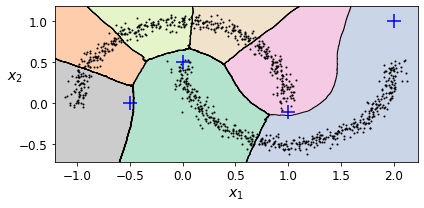

In [84]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [85]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()    # 일차원 변환

array([-1,  0,  3, -1], dtype=int64)

## 9.1.7 다른 군집 알고리즘

### 스펙트럼 군집

차원을 축소한 뒤 저차원 공간에서 또 다른 군집 알고리즘을 사용(사이킷런에선 k-평균)

In [86]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [87]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [88]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [89]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

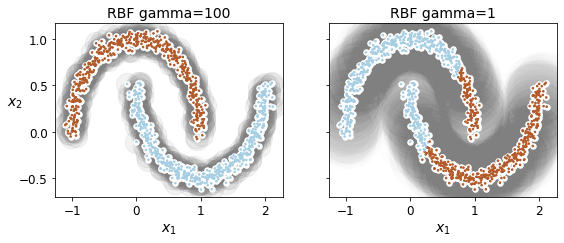

In [90]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### 병합 군집

클러스터 계층을 밑바닥부터 위로 쌓아 구성

In [91]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage='complete').fit(X)

In [92]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [93]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [94]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# 9.2 가우시안 혼합

GMM : 샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률 모델, 하나의 가우시안 분포에서 생성된 모든 샘플은 하나의 클러스터를 형성

In [95]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [97]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [104]:
print(gm.weights_, '\n')
print(gm.means_, '\n')
print(gm.covariances_)

[0.39025715 0.40007391 0.20966893] 

[[ 0.05131611  0.07521837]
 [-1.40763156  1.42708225]
 [ 3.39893794  1.05928897]] 

[[[ 0.68799922  0.79606357]
  [ 0.79606357  1.21236106]]

 [[ 0.63479409  0.72970799]
  [ 0.72970799  1.1610351 ]]

 [[ 1.14833585 -0.03256179]
  [-0.03256179  0.95490931]]]


기댓값-최대화(EM) 알고리즘 : 클러스터 파라미터를 랜덤하게 초기화하고 수렴할 때까지 (1. 기댓값 단계: 샘플을 클러스터에 할당)과 (2. 최대화 단계 : 클러스터를 업데이트)를 반복

In [105]:
# 이번 모델은 수렴에 성공
gm.converged_

True

In [107]:
# 4번째 반복만에 수렴 성공
gm.n_iter_

4

In [108]:
# 하드군집(가장 비슷한 클러스터에 할당)
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [109]:
# 소프트 군집(클러스터에 속할 확률을 예측)
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

In [110]:
# 가우시안 혼합 모델은 생성 모델이기 때문에, 이 모델에서 새로운 샘플을 만들 수 있다
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [111]:
y_new

array([0, 0, 1, 2, 2, 2])

In [112]:
# 로그 pdf를 추정할 수 있음
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

In [113]:
# 이 pdf를 전체 공간에 대해 적분하면 1이 되는지 확인
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

In [114]:
# 클러스터 결정 경계(파선)과 밀도 등고선
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: gaussian_mixtures_plot


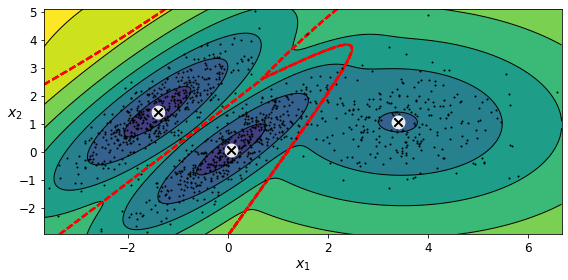

In [115]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

`covariance_type` 매개변수를 사용해 이 알고리즘이 찾을 공분산 행렬을 제한할 수 있습니다.
* `"full"`(기본값): 제약이 없습니다. 모든 클러스터가 어떤 크기의 타원도 될 수 있습니다.
* `"tied"`: 모든 클러스터가 동일하지만 어떤 타원도 가능합니다(즉, 공분산 행렬을 공유합니다).
* `"spherical"`: 모든 클러스터가 원형이지만 지름은 다를 수 있습니다(즉, 분산이 다릅니다).
* `"diag"`: 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 합니다(즉, 공분산 행렬이 대각 행렬입니다).

In [116]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [117]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


그림 저장: covariance_type_plot


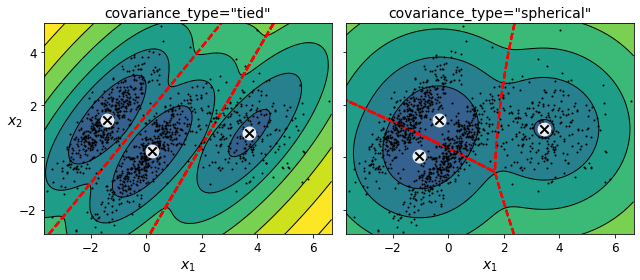

In [118]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

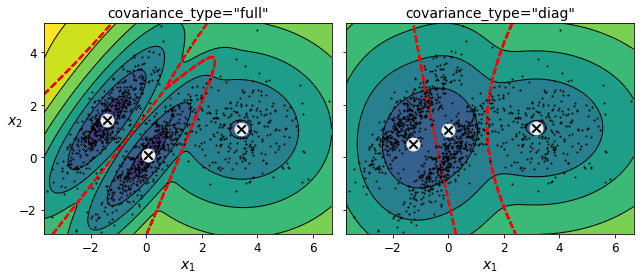

In [119]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## 9.2.1 가우시안 혼합을 사용한 이상치 탐지

밀도가 낮은 지역에 있는 모든 샘플을 이상치로 추정

In [120]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)      # 4%의 값
anomalies = X[densities < density_threshold]

그림 저장: mixture_anomaly_detection_plot


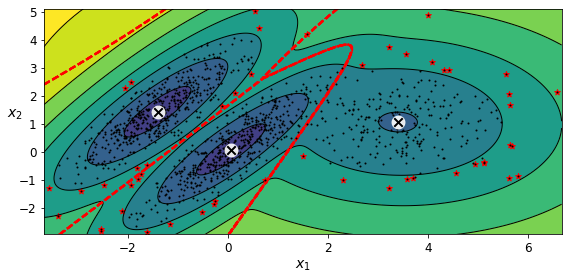

In [121]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## 9.2.2 클러스터 개수 선택하기

이너셔나 실루엣 점수는 모두 원형 클러스터를 가정하기 때문에 가우시안 혼합 모델에 사용할 수 없습니다. 대신 BIC(Bayesian Information Criterion)나 AIC(Akaike Information Criterion) 같은 이론적 정보 기준을 최소화하는 모델을 찾을 수 있습니다:

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$은 샘플의 개수입니다.
* $p$는 모델이 학습할 파라미터 개수입니다.
* $\hat L$은 모델의 가능도 함수의 최댓값입니다. 이는 모델과 최적의 파라미터가 주어졌을 때 관측 데이터 $\mathbf{X}$의 조건부 확률입니다.

BIC와 AIC 모두 모델이 많은 파라미터(예를 들면 많은 클러스터)를 학습하지 못하도록 제한합니다. 그리고 데이터에 잘 맞는 모델(즉, 관측 데이터에 가능도가 높은 모델)에 보상을 줍니다.

확률함수는 x의 함수인 반면, 가능도함수는 모수 $\theta$의 함수

In [122]:
print(gm.bic(X)); print(gm.aic(X))

8189.747000497186
8102.521720382148


In [123]:
# aic와 bic 수동 계산
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [124]:
bic, aic

(8189.747000497186, 8102.521720382148)

In [125]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

In [126]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

그림 저장: aic_bic_vs_k_plot


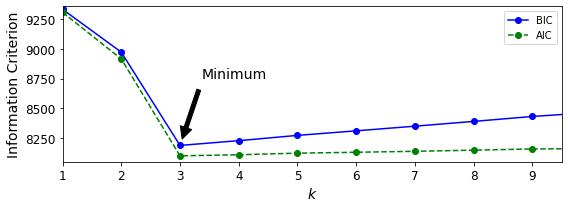

In [127]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

In [129]:
# 클러스터 개수와 covariance_type 하이퍼파라미터의 최적 조합
min_bic = np.infty      # infty는 무한대

for k in range(1, 11):
    for covariance_type in ['full', 'tied', 'spherical', 'diag']:
        bic = GaussianMixture(n_components=k, n_init=10,
                             covariance_type = covariance_type, random_state=42).fit(X).bic(X)
        
        if bic < min_bic:
            min_bic = bic
            best_covariance_type = covariance_type
            
print(best_k); print(best_covariance_type)

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

3
full


### 가능도 함수

In [130]:
from scipy.stats import norm

xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

그림 저장: likelihood_function_plot


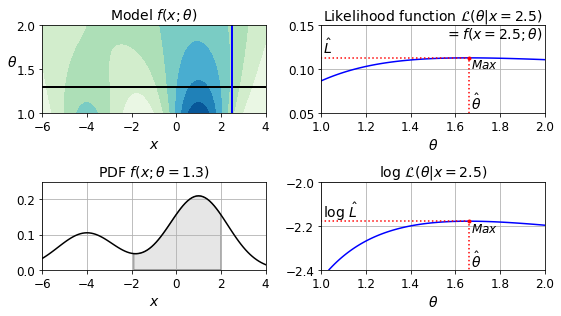

In [131]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

## 9.2.3 베이즈 가우시안 혼합 모델

최적의 클러스터 개수를 수동으로 찾기 않고 불필요한 클러스터의 가중치를 0(또는 0에 가깝게) 만드는 알고리즘, n_components 값을 최적의 클러스터 개수보다 크다고 생각하는 값으로 지정하면 됨

In [132]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2)    # 0으로 된 것이 필요없는 클러스터, 3개로 판단됨

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

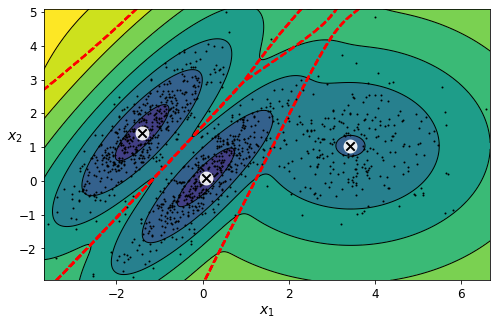

In [133]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [134]:
# weight_concentration_prior에 클러스터가 적을 것/많을 것이라는 사전 믿음을 반영
bgm_low = BayesianGaussianMixture(n_components=10, weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, weight_concentration_prior=10000, random_state=42)

nn= 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [135]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [136]:
# 사전믿음이 클 수록 더 많은 클러스터가 살아남음
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

그림 저장: mixture_concentration_prior_plot


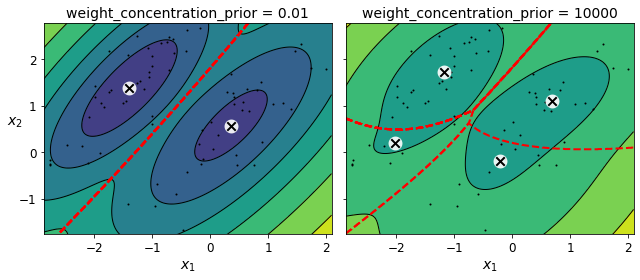

In [137]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

In [138]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [139]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

그림 저장: moons_vs_bgm_plot


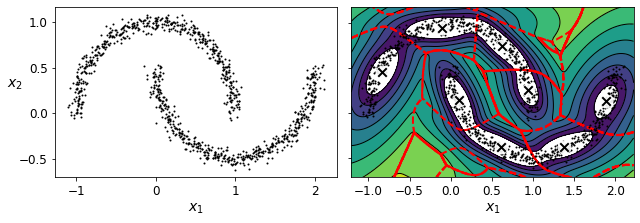

In [140]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()